In [1]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
#nltk.download('all')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
#nltk.download('omw-1.4')

In [2]:
# Read datasets
df_train = pd.read_csv(r"C:\Users\keert\OneDrive\Desktop\MINI PROJECT\training.csv",names=['Text', 'Emotion'])
df_val = pd.read_csv(r"C:\Users\keert\OneDrive\Desktop\MINI PROJECT\validation.csv",names=['Text', 'Emotion'])
df_test = pd.read_csv(r"C:\Users\keert\OneDrive\Desktop\MINI PROJECT\test.csv",names=['Text', 'Emotion'])

In [3]:
df_train['Emotion'].replace([0,1,2,3,4,5],['Sadness','Anger','Love','Surprise','Fear','Joy'],inplace=True)
df_val['Emotion'].replace([0,1,2,3,4,5],['Sadness','Anger','Love','Surprise','Fear','Joy'],inplace=True)
df_test['Emotion'].replace([0,1,2,3,4,5],['Sadness','Anger','Love','Surprise','Fear','Joy'],inplace=True)

In [4]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,Sadness
1,i can go from feeling so hopeless to so damned...,Sadness
2,im grabbing a minute to post i feel greedy wrong,Surprise
3,i am ever feeling nostalgic about the fireplac...,Love
4,i am feeling grouchy,Surprise


In [5]:
#print the shape of the data set
print(df_train.shape)

(16000, 2)


In [6]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,Sadness
1,im updating my blog because i feel shitty,Sadness
2,i never make her separate from me because i do...,Sadness
3,i left with my bouquet of red and yellow tulip...,Anger
4,i was feeling a little vain when i did this one,Sadness


In [7]:
#print the shape of the data set
print(df_test.shape)

(2000, 2)


In [8]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,Sadness
1,i feel like i am still looking at a blank canv...,Sadness
2,i feel like a faithful servant,Love
3,i am just feeling cranky and blue,Surprise
4,i can have for a treat or if i am feeling festive,Anger


In [9]:
#print the shape of the data set
print(df_val.shape)

(2000, 2)


In [10]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

Anger       5362
Sadness     4666
Surprise    2159
Fear        1937
Love        1304
Joy          572
Name: Emotion, dtype: int64

In [11]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

Anger       33.51250
Sadness     29.16250
Surprise    13.49375
Fear        12.10625
Love         8.15000
Joy          3.57500
Name: Emotion, dtype: float64

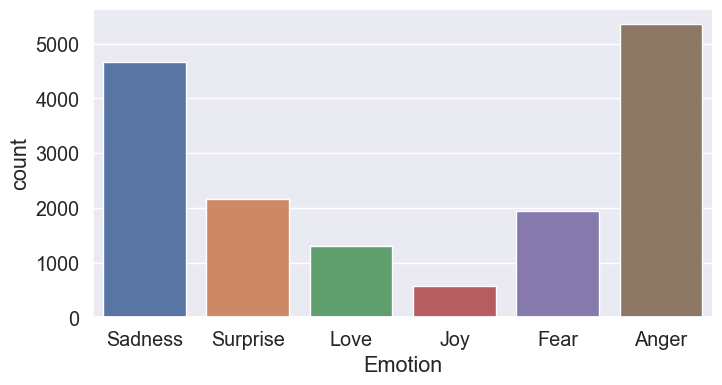

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

In [13]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [14]:
#print the number of duplicated values 
df_train.duplicated().sum()

1

In [15]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [16]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]


,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,Anger
6133,i still feel a craving for sweet food,Love
6563,i tend to stop breathing when i m feeling stre...,Surprise
7623,i was intensely conscious of how much cash i h...,Sadness
7685,im still not sure why reilly feels the need to...,Joy
8246,i am not amazing or great at photography but i...,Love
9596,ive also made it with both sugar measurements ...,Anger
9687,i had to choose the sleek and smoother feel of...,Anger
9769,i often find myself feeling assaulted by a mul...,Sadness
9786,i feel im being generous with that statement,Anger


In [17]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,Surprise
7623,i was intensely conscious of how much cash i h...,Sadness


In [18]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,Surprise
7623,i was intensely conscious of how much cash i h...,Sadness


In [19]:
df_train[df_train['Text'] == df_train.iloc[14313]['Text']]

,Text,Emotion
13653,i could feel myself hit this strange foggy wall,Fear
14313,i could feel myself hit this strange foggy wall,Joy


In [20]:
df_train[df_train['Text'] == df_train.iloc[13879]['Text']]

,Text,Emotion
7333,i feel like i am very passionate about youtube...,Anger
13879,i feel like i am very passionate about youtube...,Love


In [21]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [22]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: stop_words, dtype: int64

<Axes: ylabel='Frequency'>

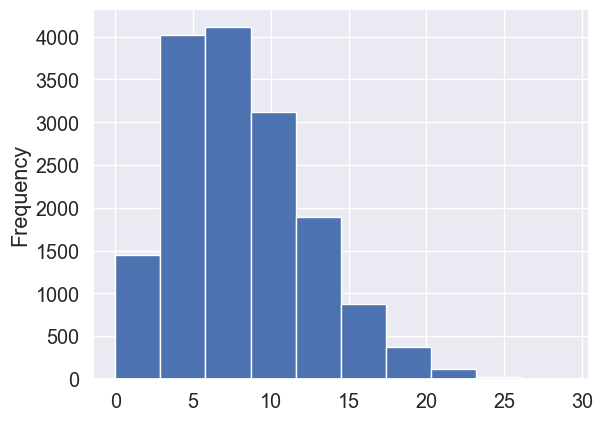

In [23]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

In [24]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

Anger       695
Sadness     581
Surprise    275
Fear        224
Love        159
Joy          66
Name: Emotion, dtype: int64

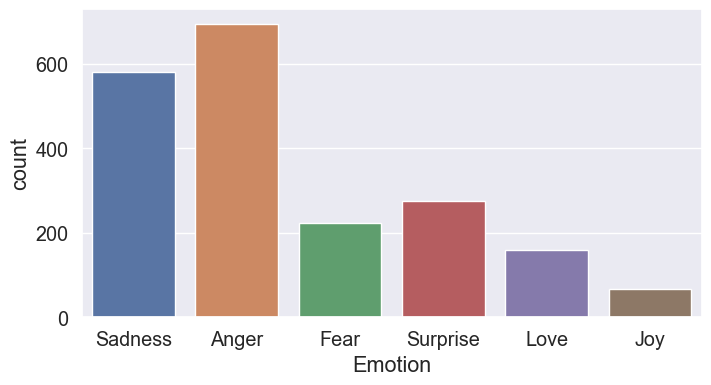

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [26]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [27]:
#print the number of duplicated values 
df_test.duplicated().sum()

0

In [28]:
#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]

,Text,Emotion


In [29]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: stop_words, dtype: int64

<Axes: ylabel='Frequency'>

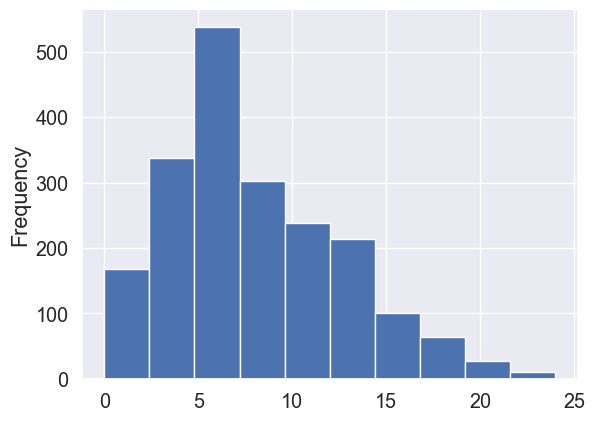

In [30]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

In [31]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

Anger       704
Sadness     550
Surprise    275
Fear        212
Love        178
Joy          81
Name: Emotion, dtype: int64

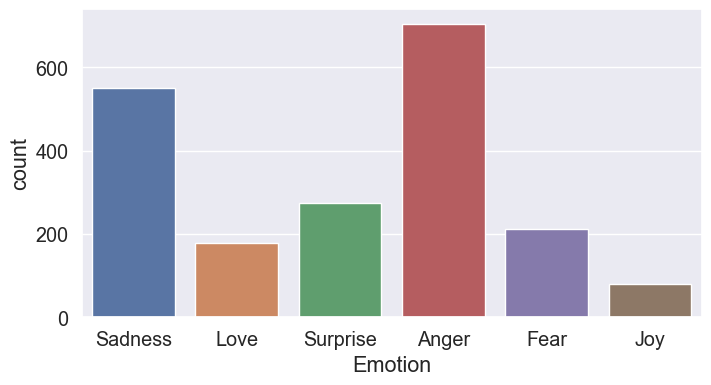

In [32]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [33]:
#print the number of null values in each column
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [34]:
#print the number of duplicated values 
df_val.duplicated().sum()

0

In [35]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,Anger
1993,i feel so tortured by it,Surprise


In [36]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]

,Text,Emotion
300,i have had several new members tell me how com...,Love
603,i have had several new members tell me how com...,Anger


In [37]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']]

,Text,Emotion
774,i feel so tortured by it,Fear
1993,i feel so tortured by it,Surprise


In [38]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [39]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: stop_words, dtype: int64

In [ ]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

In [ ]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

In [ ]:
dataframe_difference(df_train, df_test, which='both')

In [ ]:
dataframe_difference(df_train, df_val, which='both')

In [ ]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()
    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
      if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [ ]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

In [ ]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [ ]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [ ]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [ ]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

In [51]:
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [52]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['Anger'], dtype=object)

In [53]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8675 



,F1 score
Sadness,0.898260
Surprise,0.803030
Love,0.721805
Joy,0.757282
Fear,0.903057
Anger,0.852772


In [54]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Anger       0.85      0.95      0.90       704
        Fear       0.86      0.75      0.80       212
         Joy       0.92      0.59      0.72        81
        Love       0.89      0.66      0.76       178
     Sadness       0.87      0.94      0.90       550
    Surprise       0.90      0.81      0.85       275

    accuracy                           0.87      2000
   macro avg       0.88      0.78      0.82      2000
weighted avg       0.87      0.87      0.86      2000



In [55]:
#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.869 



,F1 score
Sadness,0.908178
Surprise,0.792627
Love,0.789809
Joy,0.805634
Fear,0.890909
Anger,0.850000


In [56]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Anger       0.92      0.90      0.91       704
        Fear       0.77      0.81      0.79       212
         Joy       0.82      0.77      0.79        81
        Love       0.81      0.80      0.81       178
     Sadness       0.89      0.89      0.89       550
    Surprise       0.84      0.87      0.85       275

    accuracy                           0.87      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.87      0.87      0.87      2000



In [57]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.8685 



,F1 score
Sadness,0.895264
Surprise,0.804878
Love,0.768116
Joy,0.750000
Fear,0.906997
Anger,0.853846


In [58]:
##Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       Anger       0.84      0.95      0.90       704
        Fear       0.83      0.78      0.80       212
         Joy       0.93      0.65      0.77        81
        Love       0.90      0.64      0.75       178
     Sadness       0.88      0.93      0.91       550
    Surprise       0.91      0.81      0.85       275

    accuracy                           0.87      2000
   macro avg       0.88      0.79      0.83      2000
weighted avg       0.87      0.87      0.87      2000



In [51]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.8895 



,F1 score
Sadness,0.908199
Surprise,0.870897
Love,0.634146
Joy,0.738983
Fear,0.932985
Anger,0.903461


In [52]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Anger       0.89      0.93      0.91       695
        Fear       0.85      0.89      0.87       224
         Joy       0.68      0.59      0.63        66
        Love       0.80      0.69      0.74       159
     Sadness       0.94      0.92      0.93       581
    Surprise       0.91      0.90      0.90       275

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.89      0.89      0.89      2000



In [61]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Random Forest,0.90
1,Logistic Regression,0.87
2,Decision Tree,0.87
3,Support Vector Machine,0.87


In [70]:
#c_LR = make_pipeline(tfidf, clf)
explainer_LR = LimeTextExplainer(class_names=RF.classes_)
idx  = 60
print("Actual Text : ", X_test[idx])
print("Prediction : ", RF.predict(X_test)[idx])
print("Actual :     ", y_test[idx])
exp = explainer_LR.explain_instance(X_test[idx], RF.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  woke yesterday monday morning feeling little depressed
Prediction :  Sadness
Actual :      Sadness


NEURAL NETWORKS

In [63]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [64]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [65]:
#print the labels after encoding 
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [66]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [67]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


In [68]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [69]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

17969

In [70]:
#print the index of a single word
tokenizer.word_index['towards']


209

In [71]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[51], [2], [551]]

In [72]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(3, 14318)

In [74]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [75]:
df_test.shape

(2000, 2)

In [76]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [77]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14318


In [78]:
#before
sequences_train[0]

[51, 2, 551]

In [79]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [80]:
# Read GloVE embeddings

path_to_glove_file = '/content/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [81]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 13245 words (1072 misses)


In [82]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          2863600   
                                                                 
 bidirectional (Bidirectiona  (None, 229, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 229, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

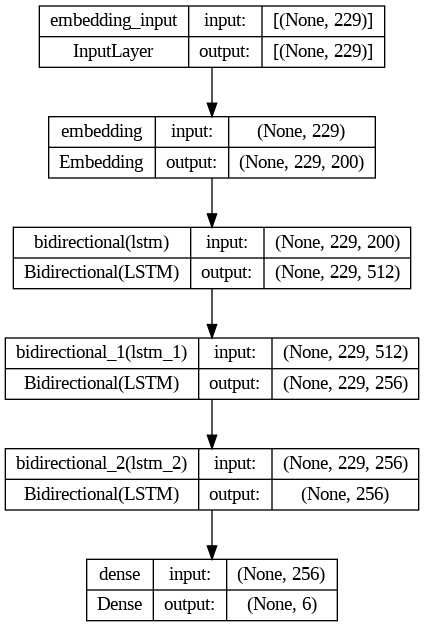

In [83]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [84]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [85]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
63/63 [==============================] - 2071s 32s/step - loss: 1.4181 - accuracy: 0.4657 - val_loss: 1.0939 - val_accuracy: 0.6215
Epoch 2/10
63/63 [==============================] - 2025s 32s/step - loss: 0.7947 - accuracy: 0.7202 - val_loss: 0.4492 - val_accuracy: 0.8560
Epoch 3/10
63/63 [==============================] - 1993s 32s/step - loss: 0.3780 - accuracy: 0.8652 - val_loss: 0.2292 - val_accuracy: 0.9125
Epoch 4/10
63/63 [==============================] - 2035s 32s/step - loss: 0.2288 - accuracy: 0.9098 - val_loss: 0.2064 - val_accuracy: 0.9140
Epoch 5/10
63/63 [==============================] - 2008s 32s/step - loss: 0.1649 - accuracy: 0.9303 - val_loss: 0.1673 - val_accuracy: 0.9290
Epoch 6/10
63/63 [==============================] - 2054s 33s/step - loss: 0.1347 - accuracy: 0.9400 - val_loss: 0.1545 - val_accuracy: 0.9245
Epoch 7/10
63/63 [==============================] - 1998s 32s/step - loss: 0.1160 - accuracy: 0.9485 - val_loss: 0.1565 - val_accuracy: 0.9285

In [86]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

63/63 [==============================] - 91s 1s/step - loss: 0.1545 - accuracy: 0.9245


[0.15450823307037354, 0.9244999885559082]

In [87]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

63/63 [==============================] - 94s 1s/step - loss: 0.1511 - accuracy: 0.9310


[0.15110506117343903, 0.9309999942779541]

In [88]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

63/63 [==============================] - 92s 1s/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       704
           1       0.89      0.90      0.89       212
           2       0.93      0.79      0.85        81
           3       0.84      0.89      0.87       178
           4       0.96      0.96      0.96       550
           5       0.91      0.95      0.93       275

    accuracy                           0.93      2000
   macro avg       0.91      0.90      0.91      2000
weighted avg       0.93      0.93      0.93      2000



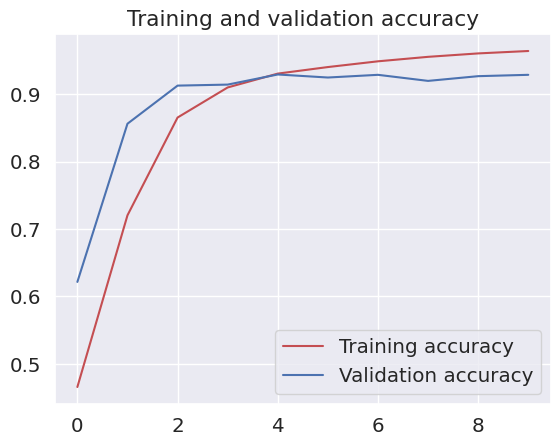

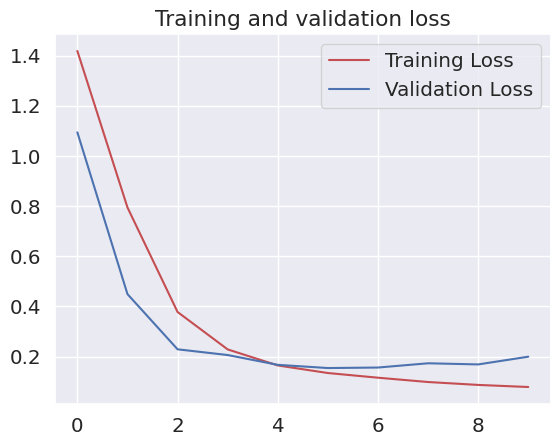

In [89]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [90]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 0s 472ms/step
Anger : 0.973482072353363


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 0s 491ms/step
Surprise : 0.7599251866340637


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 0s 499ms/step
Fear : 0.41102421283721924


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 498ms/step
Joy : 0.4055050313472748




In [91]:
sentence= 'my old brother is dead'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

my old brother is dead
1/1 [==============================] - 0s 481ms/step
Sadness : 0.5737583637237549




In [92]:
sentence= 'Im feeling sad today'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

Im feeling sad today
1/1 [==============================] - 0s 479ms/step
Sadness : 0.9992365837097168




In [93]:
model.save('Emotion Recognition From English text.h5')